<a href="https://colab.research.google.com/github/arijitiiest/Bengali-OCR/blob/master/Bangla_Digit_Recognition_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bangla Digit Recognition

In [0]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import itertools

In [7]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, AveragePooling2D, Flatten, MaxPool2D, GlobalAveragePooling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
from keras import applications

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mkdir Bangla_OCR
!mkdir -p Bangla_OCR/{data,cache}

In [3]:
cd Bangla_OCR/

/content/Bangla_OCR


In [0]:
!unzip -q /content/drive/My\ Drive/Datasets/BanglaLekha/Images.zip

### Global

In [0]:
IMG_SIZE = 32
NO_OF_CLASSES = 84

### Read Images

In [0]:
def read_images(path):
    images = []
    labels = []
    
    for file_name in os.listdir(path):
        file_path = path + '/' + file_name
        for img_name in os.listdir(file_path):
            if not img_name.startswith('.'):
                if img_name.endswith('.png'):
                    img = cv2.imread(file_path + '/' + img_name)
                    new_img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    image = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
                    images.append(image)
                    labels.append(file_name)
    return np.array(images), np.array(labels)

### Save model:

In [0]:
def save_model(model, name="model"):
    model_json = model.to_json()
    with open("models/{name}.json".format(name=name), "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("models/{name}.h5".format(name=name))
    print("Model saved")

### Model:

### Model 1 (LeNet5):

In [0]:
def train_model1():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(MaxPool2D(strides=2))
    
    model.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
    model.add(MaxPool2D(strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(84, activation='softmax'))
    
    model.build()
    model.summary()
    
    return model

### model 2 ResNet:

In [0]:
def create_model2():
    base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (IMG_SIZE,IMG_SIZE,1))
    
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    
    predictions = Dense(NO_OF_CLASSES, activation= 'softmax')(x)
    
    model = Model(inputs = base_model.input, outputs = predictions)
    
    model.summary()
    
    return model

## Main Cells

### Read Images:

In [0]:
full_data_x, full_data_y = read_images('Images')

In [15]:
print("dataset size : ", full_data_x.shape, full_data_y.shape)

dataset size :  (166105, 32, 32) (166105,)


### train and validation set:

In [0]:
train_imgs, val_imgs, train_y, val_y = train_test_split(full_data_x, full_data_y, test_size=0.2)

In [17]:
print("Train data :", train_imgs.shape, "       Label: ", train_y.shape) 
print("Validation data :", val_imgs.shape, "   Label: ", val_y.shape)

Train data : (132884, 32, 32)        Label:  (132884,)
Validation data : (33221, 32, 32)    Label:  (33221,)


### Save train, validation data:

In [0]:
np.save('data/train_imgs.npy', train_imgs)
np.save('data/train_y.npy', train_y)
np.save('data/val_imgs.npy', val_imgs)
np.save('data/val_y.npy', val_y)

### Load:

In [0]:
train_imgs = np.load('data/train_imgs.npy')
train_y = np.load('data/train_y.npy')
val_imgs = np.load('data/val_imgs.npy')
val_y = np.load('data/val_y.npy')

In [20]:
train_imgs.shape, val_imgs.shape, train_y.shape, val_y.shape

((132884, 32, 32), (33221, 32, 32), (132884,), (33221,))

### Data Visualization:

73


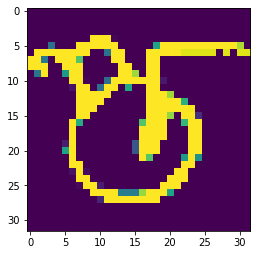

In [21]:
plt.figure(figsize=(4,10))
plt.imshow(train_imgs[0])
print(train_y[0])

### Reshape data:

In [0]:
X_train = np.reshape(train_imgs, (train_imgs.shape[0], train_imgs.shape[1], train_imgs.shape[2], 1))
X_test = np.reshape(val_imgs, (val_imgs.shape[0], val_imgs.shape[1], val_imgs.shape[2], 1))
y_train = train_y
y_test = val_y

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((132884, 32, 32, 1), (33221, 32, 32, 1), (132884,), (33221,))

In [0]:
ohe = OneHotEncoder(sparse=False )
y_ohe = ohe.fit_transform(y_train.reshape(-1, 1))

In [0]:
# Normalize inputs
# X_dev = X_train / 255.0

In [0]:
# Data Augmentation
# datagen = ImageDataGenerator(
#             rotation_range=10, 
#             width_shift_range=0.1, 
#             height_shift_range=0.1, 
#             zoom_range=0.1)
# datagen.fit(X_dev)

### Train model:

### LeNet Model:

In [27]:
model1 = train_model1()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1728)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               442624    
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [0]:
adam = Adam(lr=5e-4)
model1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [29]:
model1.fit(X_train,y_ohe,batch_size=50,epochs=20,verbose=1)

Epoch 1/20
132884/132884 [==============================] - 20s 154us/step - loss: 1.5604 - accuracy: 0.6048
Epoch 2/20
132884/132884 [==============================] - 14s 106us/step - loss: 0.6704 - accuracy: 0.8094
Epoch 3/20
132884/132884 [==============================] - 14s 104us/step - loss: 0.5173 - accuracy: 0.8500
Epoch 4/20
132884/132884 [==============================] - 14s 107us/step - loss: 0.4192 - accuracy: 0.8762
Epoch 5/20
132884/132884 [==============================] - 14s 105us/step - loss: 0.3457 - accuracy: 0.8949
Epoch 6/20
132884/132884 [==============================] - 14s 103us/step - loss: 0.2893 - accuracy: 0.9093
Epoch 7/20
132884/132884 [==============================] - 14s 105us/step - loss: 0.2451 - accuracy: 0.9222
Epoch 8/20
132884/132884 [==============================] - 14s 104us/step - loss: 0.2125 - accuracy: 0.9316
Epoch 9/20
132884/132884 [==============================] - 14s 107us/step - loss: 0.1891 - accuracy: 0.9384
Epoch 10/20
132884/

In [0]:
# Set a learning rate annealer
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
#                                 patience=3, 
#                                 verbose=1, 
#                                 factor=0.2, 
#                                 min_lr=1e-6)

In [0]:
# model1.fit_generator(datagen.flow(X_train, y_ohe, batch_size=100), steps_per_epoch=len(X_train)/100, 
#                     epochs=10, validation_data=(X_test, y_test), callbacks=[reduce_lr])

In [32]:
save_model(model1, name="LeNet_model")

Model saved


### ResNet Model:

In [35]:
model2 = create_model2()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 1)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   3200        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [0]:
adam = Adam(lr=0.0001)
model2.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model2.fit(X_train, y_ohe, epochs = 20, batch_size = 64)

Epoch 1/20
132884/132884 [==============================] - 229s 2ms/step - loss: 4.4199 - accuracy: 0.0988
Epoch 2/20
132884/132884 [==============================] - 215s 2ms/step - loss: 2.6148 - accuracy: 0.3440
Epoch 3/20
132884/132884 [==============================] - 214s 2ms/step - loss: 1.6246 - accuracy: 0.5630
Epoch 4/20
132884/132884 [==============================] - 213s 2ms/step - loss: 1.0645 - accuracy: 0.7036
Epoch 5/20
132884/132884 [==============================] - 215s 2ms/step - loss: 0.7752 - accuracy: 0.7805
Epoch 6/20
132884/132884 [==============================] - 216s 2ms/step - loss: 0.6054 - accuracy: 0.8259
Epoch 7/20
132884/132884 [==============================] - 219s 2ms/step - loss: 0.4815 - accuracy: 0.8591
Epoch 8/20
132884/132884 [==============================] - 218s 2ms/step - loss: 0.3943 - accuracy: 0.8833
Epoch 9/20
132884/132884 [==============================] - 218s 2ms/step - loss: 0.3316 - accuracy: 0.9006
Epoch 10/20
132884/132884 [=

In [41]:
save_model(model2, name="ResNet_model")

Model saved


### Testing:

In [0]:
y_test_ohe = ohe.fit_transform(y_test.reshape(-1, 1))

In [58]:
predictions = model1.evaluate(X_test,y_test_ohe)
print("Loss, Accurecy ", predictions)

33221/33221 [==============================] - 3s 87us/step
Loss, Accurecy  [1.2680880537631192, 0.8299870491027832]


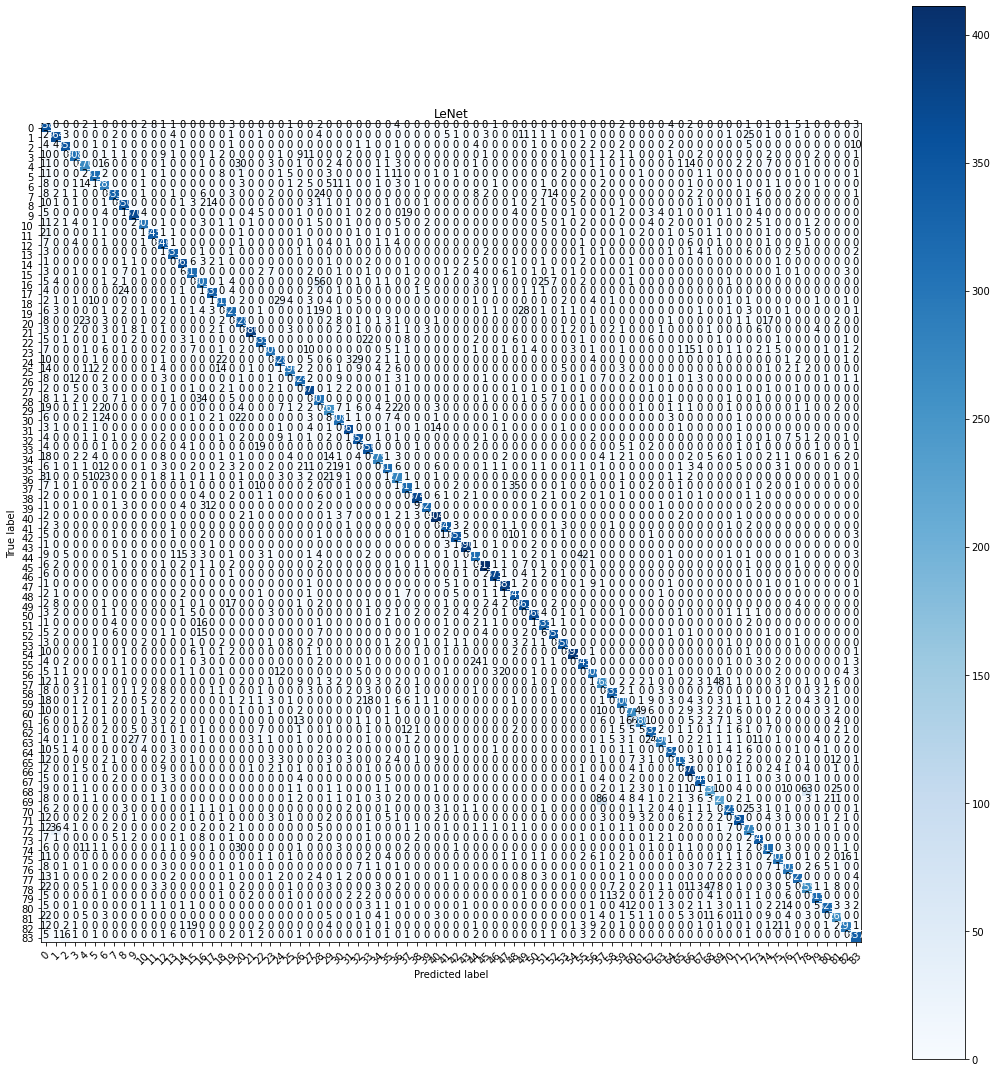

In [107]:
predictions = model1.predict(X_test)
y_pred = (predictions > 0.5)
cm = metrics.confusion_matrix(y_test_ohe.argmax(axis=1), y_pred.argmax(axis=1))

title = "LeNet"
classes = list(range(84))
path = False

cm = cm.astype(np.int64)
plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

if path:
    if filename is None:
        plt.savefig(path + title + '.png')
    else:
        plt.savefig(path + filename + '.png')
plt.show()

In [59]:
predictions = model2.evaluate(X_test,y_test_ohe)
print("Loss, Accurecy ", predictions)

33221/33221 [==============================] - 23s 689us/step
Loss, Accurecy  [0.6673274054701247, 0.8634899854660034]


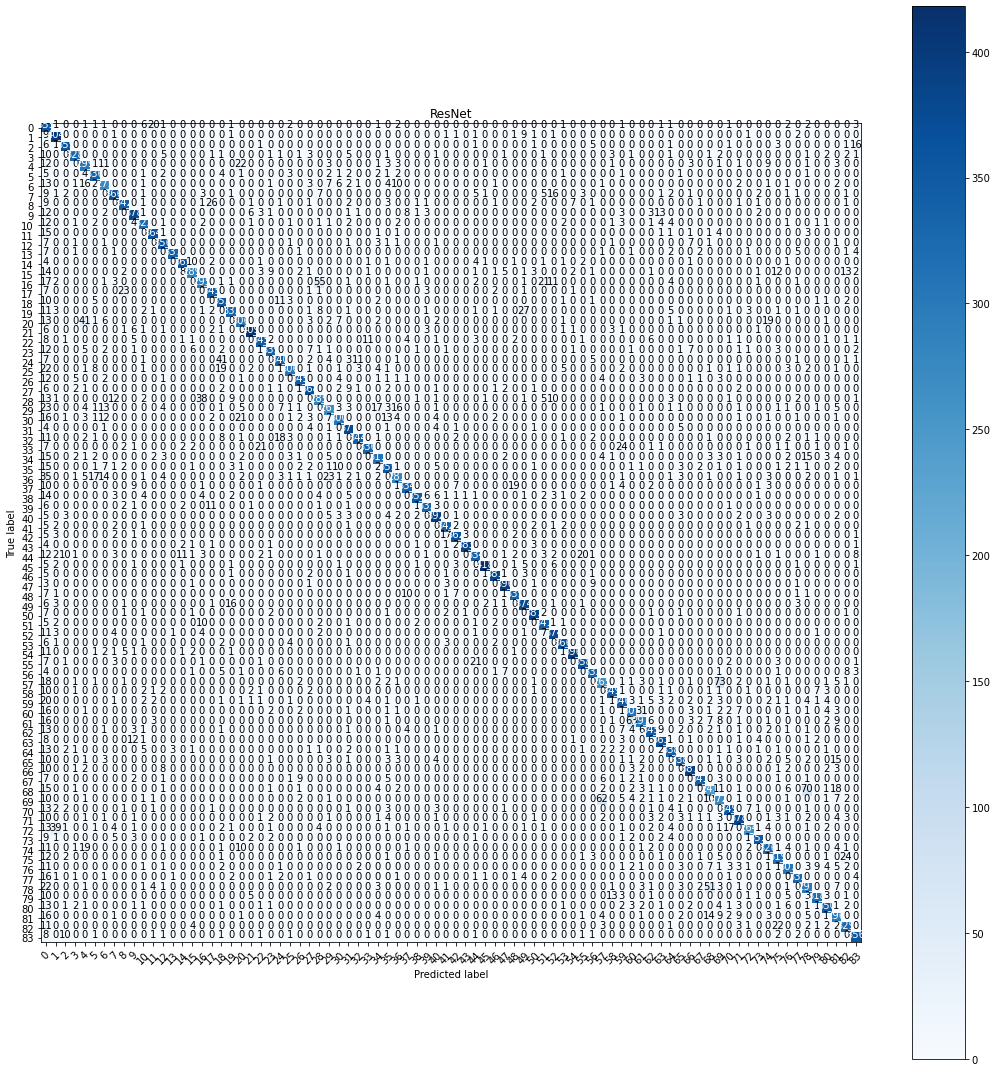

In [108]:
predictions = model2.predict(X_test)
y_pred = (predictions > 0.5)
cm = metrics.confusion_matrix(y_test_ohe.argmax(axis=1), y_pred.argmax(axis=1))

title = "ResNet"
classes = list(range(84))
path = False

cm = cm.astype(np.int64)
plt.figure(figsize=(15, 15))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

if path:
    if filename is None:
        plt.savefig(path + title + '.png')
    else:
        plt.savefig(path + filename + '.png')
plt.show()